# Sentiment analysis

## Introduction

These examples complement the Sentiment Analysis example given in the lectures. A data file has been generated containing 100 text descriptions and a corresponding sentiment score for each description. The aim is to construct a model that can predict the sentiment score from a text expression. We will consider three models:

1. Regression
2. Neural network
3. Pre-trained language model

Each model is expected to be associated with different predictive capabilities.

## Regression approach



Mounted at /content/drive/
✅ Data loaded — (102, 2)
   label                                           text
0  0.902            Absolutely outstanding performance.
1  0.837         The project exceeded all expectations.
2  0.158  A disappointing result despite strong effort.
3  0.720     The presentation was clear and articulate.
4  0.878       A deeply emotional and inspiring speech.

✅ Mean Squared Error: 0.0859
✅ R² Score: 0.3309

Sample predictions:
    Actual  Predicted
30   0.702   0.533393
67   0.083   0.515145
62   0.172   0.451606
47   0.131   0.339310
42   0.128   0.558513
40   0.992   0.464891
90   0.169   0.171511
45   0.441   0.650085
10   0.996   0.695611
0    0.902   0.729853


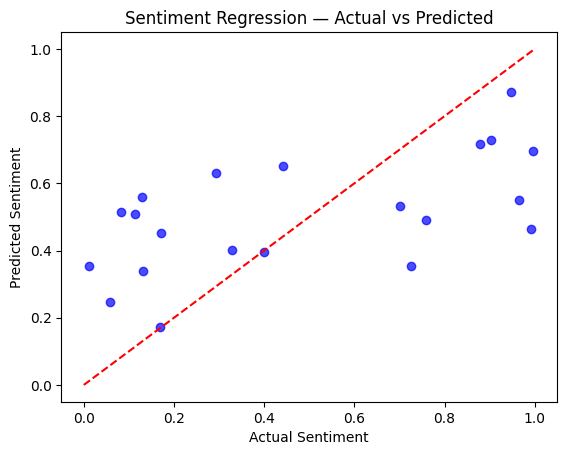

In [1]:
# ================================================================
# Text Regression — Predict Continuous Sentiment (0 = unhappy, 1 = happy)
# ================================================================

!pip install -q scikit-learn pandas matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Load your dataset
# ---------------------------
from google.colab import files
from google.colab import drive # Import drive

drive.mount('/content/drive/', force_remount=True)

filename = "/content/drive/MyDrive/formal_english_expressions_sentiment_full_range_100.txt"

# adjust path to where you stored the file in Drive
df = pd.read_csv(filename,
                 sep="\t", header=None, names=["label", "text"])

print("✅ Data loaded —", df.shape)
print(df.head())

# ---------------------------
# 2️⃣ Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# ---------------------------
# 3️⃣ TF-IDF vectorization
# ---------------------------
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ---------------------------
# 4️⃣ Regression model
# ---------------------------
model = LinearRegression()
model.fit(X_train_tfidf, y_train)

# ---------------------------
# 5️⃣ Evaluate
# ---------------------------
y_pred = model.predict(X_test_tfidf)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Mean Squared Error: {mse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# ---------------------------
# 6️⃣ Compare predictions
# ---------------------------
comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print("\nSample predictions:")
print(comparison.head(10))

# ---------------------------
# 7️⃣ Visualization
# ---------------------------
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Sentiment Regression — Actual vs Predicted")
plt.show()

## Neural Network approach

In this example, we use a neural network based regression which allows for non-linear relationships.

In [ ]:
# ================================================================
# Text Regression with Neural Network (PyTorch)
# ================================================================

!pip install -q torch scikit-learn pandas matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(max_features=500)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# ---------------------------
# 3️⃣ Define neural network model
# ---------------------------
class SentimentRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # single output for regression
        )
    def forward(self, x):
        return self.net(x)

model = SentimentRegressor(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 4️⃣ Train loop
# ---------------------------
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f}")

# ---------------------------
# 5️⃣ Evaluate
# ---------------------------
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n✅ Test Mean Squared Error: {mse:.4f}")
print(f"✅ Test R² Score: {r2:.4f}")

# ---------------------------
# 6️⃣ Compare Predictions
# ---------------------------
comparison = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": preds
})
print("\nSample predictions:")
print(comparison.head(10))

# ---------------------------
# 7️⃣ Visualization
# ---------------------------
plt.scatter(y_test, preds, color='blue', alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Sentiment (0 = sad, 1 = happy)")
plt.ylabel("Predicted Sentiment")
plt.title("Neural Network Regression — Actual vs Predicted")
plt.show()


Epoch [10/100] | Loss: 0.3096
Epoch [20/100] | Loss: 0.1537
Epoch [30/100] | Loss: 0.0501
Epoch [40/100] | Loss: 0.0323
Epoch [50/100] | Loss: 0.0108
Epoch [60/100] | Loss: 0.0044
Epoch [70/100] | Loss: 0.0029


## Pre-trained language model approach

The following two examples uses a DistilBERT pre-trained BERT model to analyse the text. The first example uses a regression head while the second uses a more flexible MLP (after freezing the encoder).

In [ ]:
# ================================================================
# DistilBERT Regression — Predicting Continuous Sentiment (0 to 1)
# ================================================================

!pip install -q transformers torch datasets scikit-learn pandas matplotlib

import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertModel, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive/', force_remount=True)

# adjust path to where you stored the file in Drive
df = pd.read_csv(filename,
                 sep="\t", header=None, names=["label", "text"])

print("✅ Data loaded —", df.shape)
print(df.head())

# ---------------------------
# 2️⃣ Prepare train/test split
# ---------------------------
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# ---------------------------
# 3️⃣ Tokenize
# ---------------------------
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_enc = tokenizer(list(train_df["text"]), truncation=True, padding=True)
test_enc  = tokenizer(list(test_df["text"]),  truncation=True, padding=True)

train_dataset = HFDataset.from_dict({
    "input_ids": train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "labels": train_df["label"].astype(float).tolist()
})
test_dataset = HFDataset.from_dict({
    "input_ids": test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"],
    "labels": test_df["label"].astype(float).tolist()
})

# ---------------------------
# 4️⃣ Load DistilBERT for regression
# ---------------------------
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,          # continuous output
    problem_type="regression"  # use MSELoss automatically
)

# ---------------------------
# 5️⃣ Training setup
# ---------------------------
training_args = TrainingArguments(
    output_dir="./distilbert_regression_results",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="no",
    report_to=[],             # disable W&B/TensorBoard
    logging_strategy="steps",
    logging_steps=10,
    disable_tqdm=False,
)

# Metric function for evaluation
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.squeeze()
    mse = mean_squared_error(labels, preds)
    r2 = r2_score(labels, preds)
    return {"mse": mse, "r2": r2}

# ---------------------------
# 6️⃣ Trainer
# ---------------------------
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ---------------------------
# 7️⃣ Train the model
# ---------------------------

# 🔒 Freeze the entire DistilBERT encoder
for param in model.distilbert.parameters():
    param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"🧊 Encoder frozen. Training only {trainable_params}/{total_params} parameters (~{100*trainable_params/total_params:.2f}% of model).")


print("\n🚀 Fine-tuning DistilBERT for regression...\n")
trainer.train()

# ---------------------------
# 8️⃣ Evaluate
# ---------------------------
print("\n📊 Evaluating...")
results = trainer.evaluate()
print(f"\n✅ MSE: {results['eval_mse']:.4f}")
print(f"✅ R² Score: {results['eval_r2']:.4f}")

# ---------------------------
# 9️⃣ Predictions
# ---------------------------
preds = trainer.predict(test_dataset).predictions.squeeze()
actual = np.array(test_df["label"])

comparison = pd.DataFrame({"Actual": actual, "Predicted": preds})
print("\nSample predictions:")
print(comparison.head(10))

# ---------------------------
# 🔟 Visualization
# ---------------------------
plt.scatter(actual, preds, alpha=0.7, color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Sentiment (0 = sad, 1 = happy)")
plt.ylabel("Predicted Sentiment")
plt.title("DistilBERT Regression — Actual vs Predicted")
plt.show()

In [ ]:
# ================================================================
# DistilBERT Regression with Custom MLP Head (Feature Extractor Style)
# ================================================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# 2️⃣ Tokenize
# ---------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_enc = tokenizer(list(train_df["text"]), truncation=True, padding=True)
test_enc  = tokenizer(list(test_df["text"]), truncation=True, padding=True)

train_dataset = HFDataset.from_dict({
    "input_ids": train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "labels": train_df["label"].astype(float).tolist()
})
test_dataset = HFDataset.from_dict({
    "input_ids": test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"],
    "labels": test_df["label"].astype(float).tolist()
})

# ---------------------------
# 3️⃣ Custom model with MLP head
# ---------------------------
class DistilBertRegressor(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()   # keep outputs in [0,1]
        )
        # Freeze encoder initially
        for p in self.encoder.parameters():
            p.requires_grad = False

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = out.last_hidden_state[:,0]  # [CLS]

        # Handle batch size of 1 for BatchNorm1d during training
        if pooled.size(0) == 1 and self.training:
             preds = self.head[:2](pooled) # Apply first two layers (Linear and ReLU)
             preds = self.head[3:](preds) # Apply rest of the layers (Dropout, Linear, ReLU, Linear, Sigmoid), skipping BatchNorm
        else:
             preds = self.head(pooled)

        if labels is not None:
            loss_fn = nn.MSELoss()
            # Ensure labels and preds have the same shape by squeezing both
            loss = loss_fn(preds.squeeze(), labels.squeeze())
            return {"loss": loss, "logits": preds}
        return {"logits": preds}

model = DistilBertRegressor(model_name)

# ---------------------------
# 4️⃣ Trainer
# ---------------------------
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.squeeze()
    labels = labels.squeeze() # Squeeze labels here as well
    mse = mean_squared_error(labels, preds)
    r2 = r2_score(labels, preds)
    return {"mse": mse, "r2": r2}

training_args = TrainingArguments(
    output_dir="./mlp_regression_head",
    num_train_epochs=15,
    per_device_train_batch_size=16, # Increased batch size
    learning_rate=2e-4,          # higher since only head is trained
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    report_to=[],
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ---------------------------
# 5️⃣ Train
# ---------------------------
print("\n🚀 Training custom MLP regression head (encoder frozen)...\n")
trainer.train()

# ---------------------------
# 6️⃣ Evaluate
# ---------------------------
results = trainer.evaluate()
print(f"\n✅ Test MSE: {results['eval_mse']:.4f}")
print(f"✅ Test R²:  {results['eval_r2']:.4f}")

# ---------------------------
# 7️⃣ Predict & Plot
# ---------------------------
preds = trainer.predict(test_dataset).predictions.squeeze()
actual = np.array(test_df["label"])
plt.scatter(actual, preds, color="blue", alpha=0.7)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("Actual Sentiment (0=sad,1=happy)")
plt.ylabel("Predicted Sentiment")
plt.title("DistilBERT + MLP Regression Head")
plt.show()